# Step 4: Creating Decision Tree Regressor and Random Forest Regressor from scratch

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from collections import Counter

from helper_functions import (
    calculate_mse, calculate_rmse, calculate_mae, calculate_r2, regression_metrics,
    plot_distribution,
    plot_actual_vs_predicted,
    plot_summary_statistics,
    plot_histograms_parallel,
    plot_histograms_stacked
)

In [2]:
current_dir = os.getcwd()
dir_contents = os.listdir(current_dir)

for filename in dir_contents:
    file_path = os.path.join(current_dir, filename)
    if os.path.isfile(file_path):
        print(filename)

creating_dataframe.ipynb
data_analysis.ipynb
data_preprocessing.ipynb
dt_and_rf_from_scratch.ipynb
helper_functions.py
sklearn_dt_and_rf.ipynb


In [3]:
df = pd.read_csv('../dataset/failed_hdds_with_rul.csv')

In [4]:
df.shape

(18588, 31)

In [5]:
df.head()

,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,...,smart_193_raw,smart_194_normalized,smart_194_raw,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw,date_diff_days
0,4000787030016,0,119.0,208663312.0,92.0,0.0,100.0,9.0,100.0,0.0,...,7273.0,23.0,23.0,100.0,0.0,100.0,0.0,200.0,0.0,26
1,12000138625024,0,79.0,155920208.0,98.0,0.0,100.0,2.0,100.0,24.0,...,633.0,40.0,40.0,100.0,88.0,100.0,88.0,200.0,0.0,26
2,8001563222016,0,77.0,54823024.0,98.0,0.0,100.0,2.0,100.0,0.0,...,14936.0,29.0,29.0,100.0,0.0,100.0,0.0,200.0,0.0,52
3,12000138625024,0,84.0,235330528.0,94.0,0.0,100.0,5.0,100.0,0.0,...,1501.0,25.0,25.0,100.0,0.0,100.0,0.0,200.0,0.0,83
4,8001563222016,0,67.0,240427784.0,95.0,0.0,100.0,4.0,100.0,3896.0,...,14353.0,38.0,38.0,100.0,0.0,100.0,0.0,200.0,0.0,27


### Checking the lowest and highest values for RUL

In [6]:
min_value = df['date_diff_days'].min()
max_value = df['date_diff_days'].max()
print(f'Target values should range from {min_value} to {max_value} days')

Target values should range from 0 to 88 days


In [7]:
RUL = df['date_diff_days'].values
RUL

array([26, 26, 52, ...,  0,  0,  0], dtype=int64)

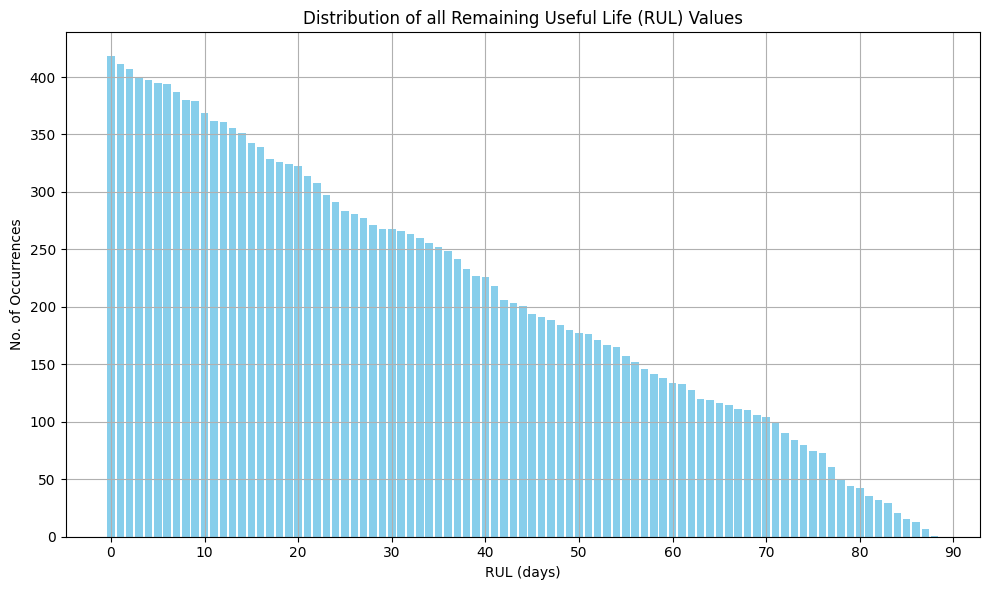

In [8]:
plot_distribution(RUL, 
                  title='Distribution of all Remaining Useful Life (RUL) Values', 
                  xlabel='RUL (days)', 
                  ylabel='No. of Occurrences', 
                  save_path='../img/rul_distribution.png')

### Creating train and test splits

In [9]:
X = df.drop(['date_diff_days'], axis=1).values

In [10]:
y = df['date_diff_days'].values

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Decision Tree

### Implementing a decision tree regressor from scratch

In [12]:
class Node:
    def __init__(self, feature_index=None, threshold=None, 
                 left=None, right=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        
    def is_leaf(self):
        return self.value is not None


class DecisionTreeRegressor:
    def __init__(self, max_depth=None, min_samples_split=2, 
                 feature_selection=False):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.feature_selection = feature_selection
        self.tree = None

    def fit(self, X, y):
        self.tree = self.grow_tree(X, y)

    def grow_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape

        # 1. Stopping conditions
        if depth == self.max_depth or num_samples < self.min_samples_split:
            leaf_value = np.mean(y)
            return Node(value=leaf_value)

        # 2. Find the best split
        feature_index, threshold = self.best_split(X, y)

        # 3. Stopping conditions if no valid split found
        if feature_index is None:
            return Node(value=np.mean(y))
        if threshold is None:
            return Node(value=np.mean(y))

        # 4. Create boolean arrays for left and right splits
        indices_left = X[:, feature_index] <= threshold
        indices_right = X[:, feature_index] > threshold
        
        # 5. Use the boolean arrays to create subsets of data for left and right splits
        X_left, y_left = X[indices_left], y[indices_left]
        X_right, y_right = X[indices_right], y[indices_right]

        # 6. Recursively grow left and right subtrees
        left_subtree = self.grow_tree(X_left, y_left, depth + 1)
        right_subtree = self.grow_tree(X_right, y_right, depth + 1)

        # 7. Create and return the current node
        return Node(feature_index=feature_index, threshold=threshold, 
                    left=left_subtree, right=right_subtree)

    def best_split(self, X, y):
        num_samples, num_features = X.shape

        # 1. Check if there is only one sample or fewer, cannot split
        if num_samples <= 1:
            return None, None  

        # 2. Calculate the variance of the entire dataset
        var_parent = np.var(y)
        
        # 3. Initialise variables
        best_var_reduction = 0
        best_split = None, None
        column_indices = list(range(num_features))
        
        # Adding feature selection for the random forest
        if self.feature_selection:
            column_indices = np.random.choice(a=column_indices, 
                                              size=int(np.sqrt(num_features)), 
                                              replace=False)
        
        # 4. Loop through each feature/column
        for feature_index in column_indices:
            # Get the unique values in the current feature
            thresholds = np.unique(X[:, feature_index])
            
            # 5. Loop through each unique value as a potential threshold
            for threshold in thresholds:
                # Create boolean arrays for the left and right splits
                indices_left = X[:, feature_index] <= threshold
                indices_right = X[:, feature_index] > threshold
                
                # Filter y to get the left and right subsets
                y_left = y[indices_left]
                y_right = y[indices_right]

                # 6. Skip the split if either side has too few samples
                if len(y_left) < self.min_samples_split or len(y_right) < self.min_samples_split:
                    continue

                # 7. Calculate the weighted variance of the child nodes
                weighted_var_child = ((len(y_left) / num_samples) * np.var(y_left) +
                                      (len(y_right) / num_samples) * np.var(y_right))

                # Calculate the variance reduction
                var_reduction = var_parent - weighted_var_child

                # 8. Update the best split if the variance reduction is higher
                if var_reduction > best_var_reduction:
                    best_var_reduction = var_reduction
                    best_split = (feature_index, threshold)
        
        return best_split

    def print_tree(self, node=None, indent='  '):
        if node is None:
            node = self.tree

        if node.is_leaf():
            # print(node.value)
            print(f'{node.value:.4f}')
        else:
            print(f'X{node.feature_index} <= {node.threshold}')

            print(f'{indent}Left: ', end='')
            self.print_tree(node.left, indent + '  ')

            print(f'{indent}Right: ', end='')
            self.print_tree(node.right, indent + '  ')


    def predict(self, X):
        return np.array([self.traverse_tree(x, self.tree) for x in X])

    def traverse_tree(self, x, node):
        if node.is_leaf():
            return node.value

        if x[node.feature_index] <= node.threshold:
            return self.traverse_tree(x, node.left)
        return self.traverse_tree(x, node.right)

### Testing the print tree function

In [13]:
%%time

dtr = DecisionTreeRegressor(max_depth=2, min_samples_split=2)
dtr.fit(X_train, y_train)
dtr.print_tree()
y_pred = dtr.predict(X_test)

regression_metrics(y_test, y_pred, model_name='simple tree')

X1 <= 0.0
  Left: X9 <= 368.0
    Left: 31.4457
    Right: 18.2194
  Right: 0.0000
Model: simple tree

CPU times: total: 17.7 s
Wall time: 18.4 s


{'MSE': 416.56716108923246,
 'RMSE': 20.409976998743346,
 'MAE': 16.975422685654866,
 'R2 score': 0.06248898603904607}

### Applying hyperparamater tuning to find the most optimal parameter values

In [17]:
%%time

hyperparameter_values = {'max_depth': [], 'min_samples_split': [], 'mse': [], 'rmse': [], 'mae': [], 'r2': []}

for max_depth in range(2, 41, 2):
    for min_samples_split in range(2, 5, 2):
        tree = DecisionTreeRegressor(max_depth=max_depth, min_samples_split=min_samples_split)
        tree.fit(X_train, y_train)
        y_pred = tree.predict(X_test)
        
        mse = calculate_mse(y_test, y_pred)
        rmse = calculate_rmse(y_test, y_pred)
        mae = calculate_mae(y_test, y_pred)
        r2 = calculate_r2(y_test, y_pred)
        
        hyperparameter_values['max_depth'].append(max_depth)
        hyperparameter_values['min_samples_split'].append(min_samples_split)
        hyperparameter_values['mse'].append(mse)
        hyperparameter_values['rmse'].append(rmse)
        hyperparameter_values['mae'].append(mae)
        hyperparameter_values['r2'].append(r2)
        
hyperparameter_df = pd.DataFrame(hyperparameter_values)
hyperparameter_df.sort_values('rmse').head()

CPU times: total: 31min 1s
Wall time: 36min 20s


,max_depth,min_samples_split,mse,rmse,mae,r2
36,38,2,31.083789,5.575284,2.482024,0.930044
34,36,2,31.083789,5.575284,2.482024,0.930044
32,34,2,31.083789,5.575284,2.482024,0.930044
38,40,2,31.083789,5.575284,2.482024,0.930044
30,32,2,31.083789,5.575284,2.482024,0.930044


In [20]:
hyperparameter_df.sort_values('rmse').head(10)

,max_depth,min_samples_split,mse,rmse,mae,r2
36,38,2,31.083789,5.575284,2.482024,0.930044
34,36,2,31.083789,5.575284,2.482024,0.930044
32,34,2,31.083789,5.575284,2.482024,0.930044
38,40,2,31.083789,5.575284,2.482024,0.930044
30,32,2,31.083789,5.575284,2.482024,0.930044
28,30,2,31.086210,5.575501,2.482831,0.930038
26,28,2,31.091323,5.575959,2.483880,0.930027
24,26,2,31.123336,5.578829,2.487817,0.929955
22,24,2,31.168966,5.582917,2.500630,0.929852
20,22,2,31.513860,5.613721,2.533524,0.929076


### Re-training and testing with the best hyperparameters

In [13]:
%%time

dtr = DecisionTreeRegressor(max_depth=32, min_samples_split=2)
dtr.fit(X_train, y_train)
y_pred_dtr = dtr.predict(X_test)

regression_metrics(y_test, y_pred_dtr, model_name='Decision Tree Tuned')

Model: Decision Tree Tuned

CPU times: total: 58.6 s
Wall time: 1min 1s


{'MSE': 31.08378907417369,
 'RMSE': 5.575283766246673,
 'MAE': 2.48202438587054,
 'R2 score': 0.9300439464875757}

### Plotting actual vs predicted values

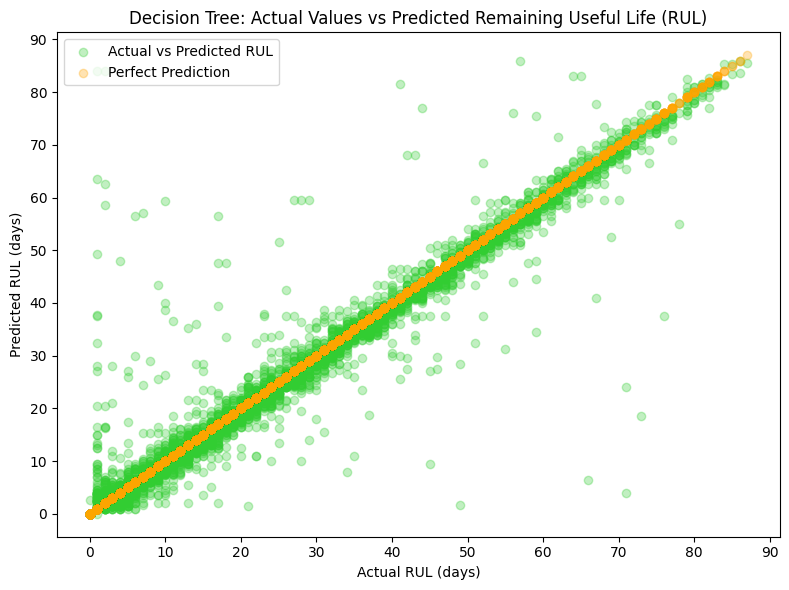

In [99]:
plot_actual_vs_predicted(y_true=y_test, 
                         y_pred=y_pred_dtr, 
                         title='Decision Tree: Actual Values vs Predicted Remaining Useful Life (RUL)', 
                         save_path='../img/decision_tree.png')

### Compare summary statistics

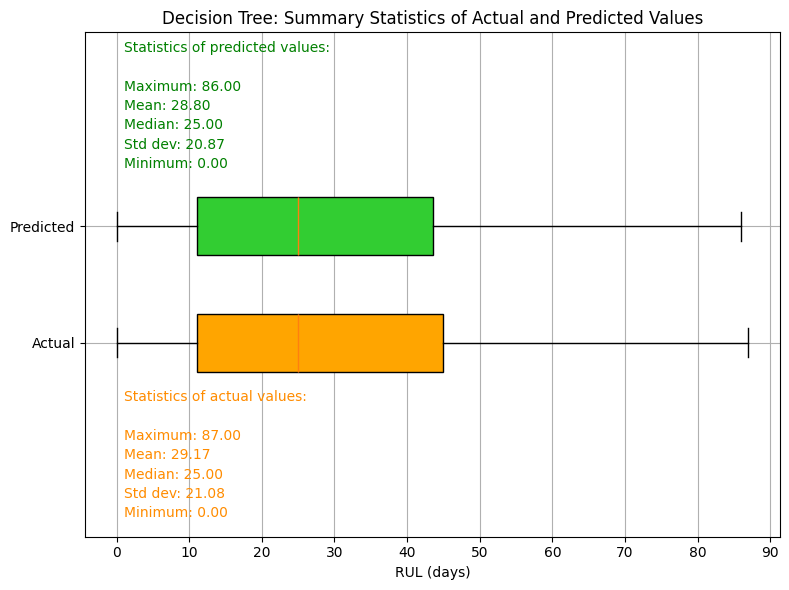

In [120]:
plot_summary_statistics(y_true=y_test, 
                        y_pred=y_pred_dtr,
                        title='Decision Tree: Summary Statistics of Actual and Predicted Values',
                        save_path='../img/box_plot_decision_tree.png')

### Compare RUL distributions

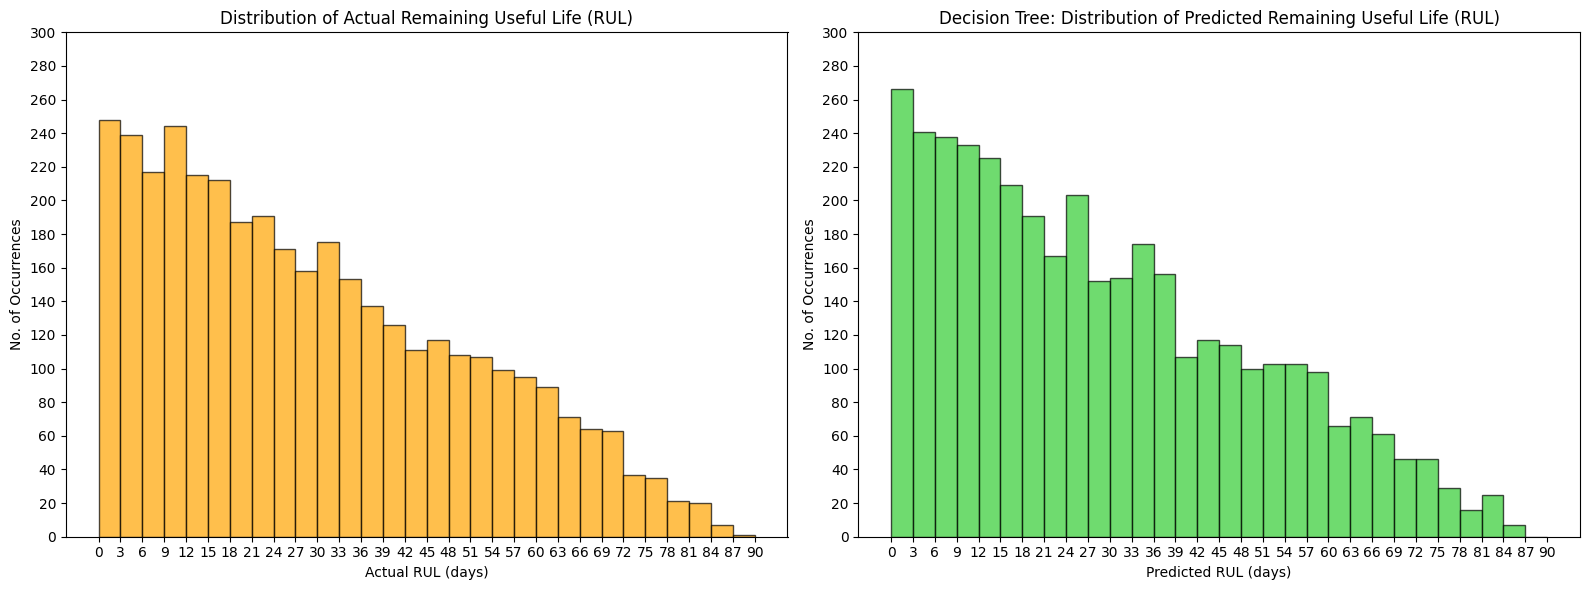

In [113]:
plot_histograms_parallel(y_true=y_test,
                         y_pred=y_pred_dtr,
                         titles=("Distribution of Actual Remaining Useful Life (RUL)", "Decision Tree: Distribution of Predicted Remaining Useful Life (RUL)"),
                         save_path='../img/histogram_parallel_decision_tree.png')

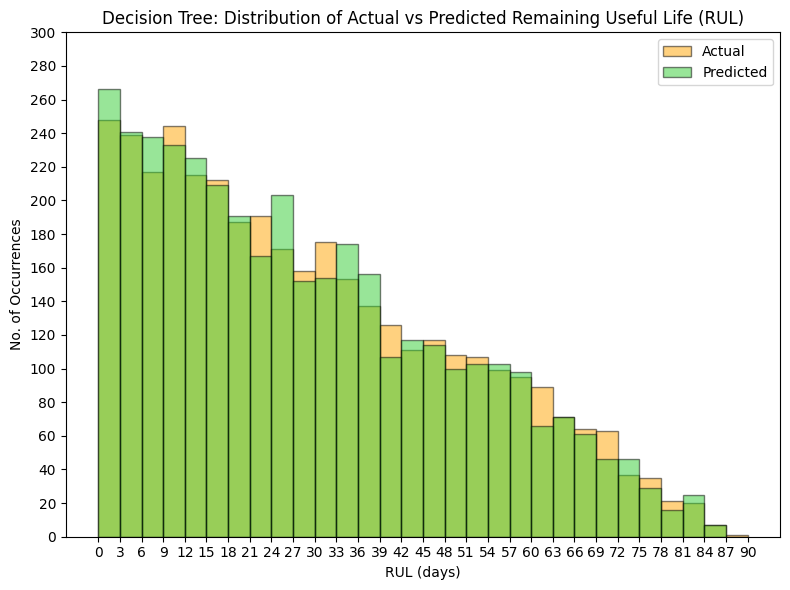

In [114]:
plot_histograms_stacked(y_true=y_test, 
                        y_pred=y_pred_dtr, 
                        title="Decision Tree: Distribution of Actual vs Predicted Remaining Useful Life (RUL)",
                        save_path='../img/histogram_stacked_tree.png')

# Random Forest

### Implementing a random forest regressor from scratch

In [14]:
class RandomForestRegressor:
    def __init__(self, n_trees=100, max_depth=None, min_samples_split=2, 
                 feature_selection=True, random_state=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.feature_selection = feature_selection
        self.random_state = random_state
        self.trees = []
        
    def fit(self, X, y):
        np.random.seed(self.random_state)
        for _ in range(self.n_trees):
            # Perform bootstrap sampling (pick random values from the X_train samples)
            bootstrap_indices = np.random.choice(len(X), len(X), replace=True)
            # Create a new dataset using the bootstrap indices
            X_bootstrap, y_bootstrap = X[bootstrap_indices], y[bootstrap_indices]
            
            tree = DecisionTreeRegressor(max_depth=self.max_depth, 
                                         min_samples_split=self.min_samples_split, 
                                         feature_selection=self.feature_selection)
            tree.fit(X_bootstrap, y_bootstrap)
            self.trees.append(tree)
    
    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        predictions = np.mean(predictions, axis=0)  # Calculating the mean of each column
        return predictions

### Confirming reproducibility of random forest with feature selection

In [39]:
results = []

for i in range(5):
    rfr = RandomForestRegressor(n_trees=10, max_depth=10, min_samples_split=2, feature_selection=True, random_state=0)
    rfr.fit(X_train, y_train)
    y_pred_rfr = rfr.predict(X_test)

    result = regression_metrics(y_test, y_pred_rfr)
    results.append(result)
    
all_same = all(result.items() == results[0].items() for result in results)
print("Are all results the same?", all_same)

Are all results the same? True


### Random forest WITH feature selection using hyperparameter tuned values obtained from sklearn's random forest regressor

In [45]:
%%time

rfr = RandomForestRegressor(n_trees=88, max_depth=70, min_samples_split=2, feature_selection=True, random_state=0)
rfr.fit(X_train, y_train)
y_pred_rfr = rfr.predict(X_test)

regression_metrics(y_test, y_pred_rfr, model_name='Random forest tuned with feature selection: best values')

Model: Random forest tuned with feature selection: best values

CPU times: total: 11min 48s
Wall time: 12min 21s


{'MSE': 44.190896488370754,
 'RMSE': 6.647623371429127,
 'MAE': 4.814663326472104,
 'R2 score': 0.9005455637301629}

### Random forest WITHOUT feature selection using hyperparameter tuned values obtained from sklearn's random forest regressor

In [19]:
%%time

rfr = RandomForestRegressor(n_trees=88, max_depth=70, min_samples_split=2, feature_selection=False, random_state=0)
rfr.fit(X_train, y_train)
y_pred_rfr = rfr.predict(X_test)

regression_metrics(y_test, y_pred_rfr, model_name='Random forest tuned without feature selection: best values')

Model: Random forest tuned without feature selection: best values

CPU times: total: 1h 3min 24s
Wall time: 1h 7min 39s


{'MSE': 14.218392691193873,
 'RMSE': 3.7707284032655908,
 'MAE': 2.302948313760655,
 'R2 score': 0.968000598717476}

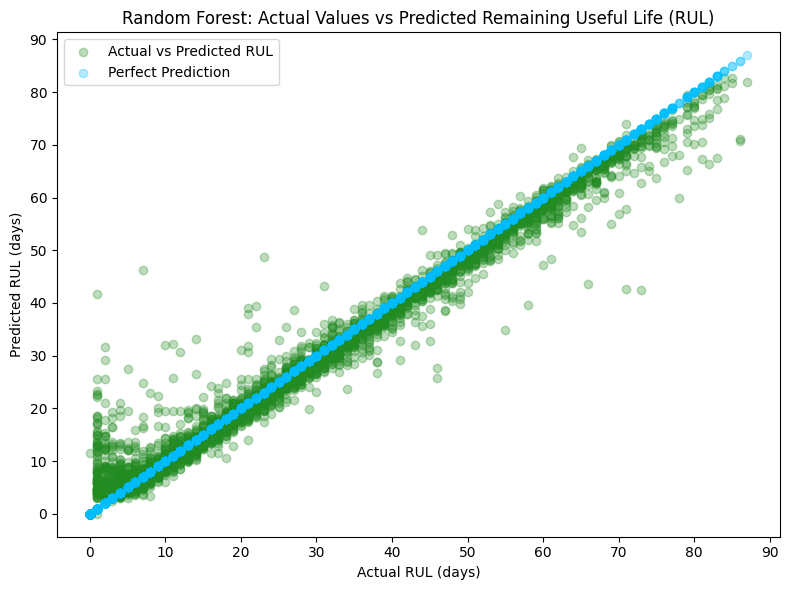

In [115]:
plot_actual_vs_predicted(y_true=y_test, 
                         y_pred=y_pred_rfr, 
                         title='Random Forest: Actual Values vs Predicted Remaining Useful Life (RUL)', 
                         true_color='deepskyblue', 
                         predicted_color='forestgreen',
                         save_path='../img/random_forest.png')

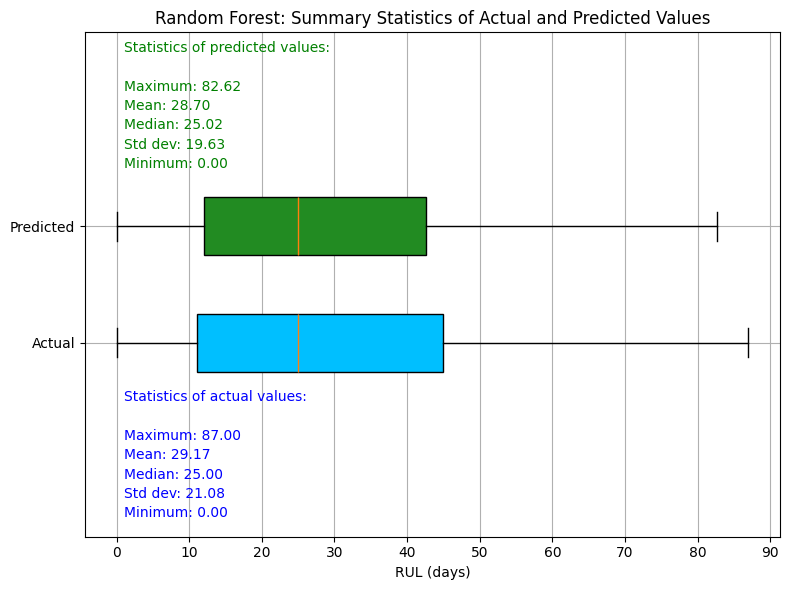

In [121]:
plot_summary_statistics(y_true=y_test, 
                        y_pred=y_pred_rfr,
                        title='Random Forest: Summary Statistics of Actual and Predicted Values',
                        true_color='deepskyblue', 
                        pred_color='forestgreen', 
                        text_color_t='blue', 
                        text_color_p='green', 
                        save_path='../img/box_plot_random_forest.png')

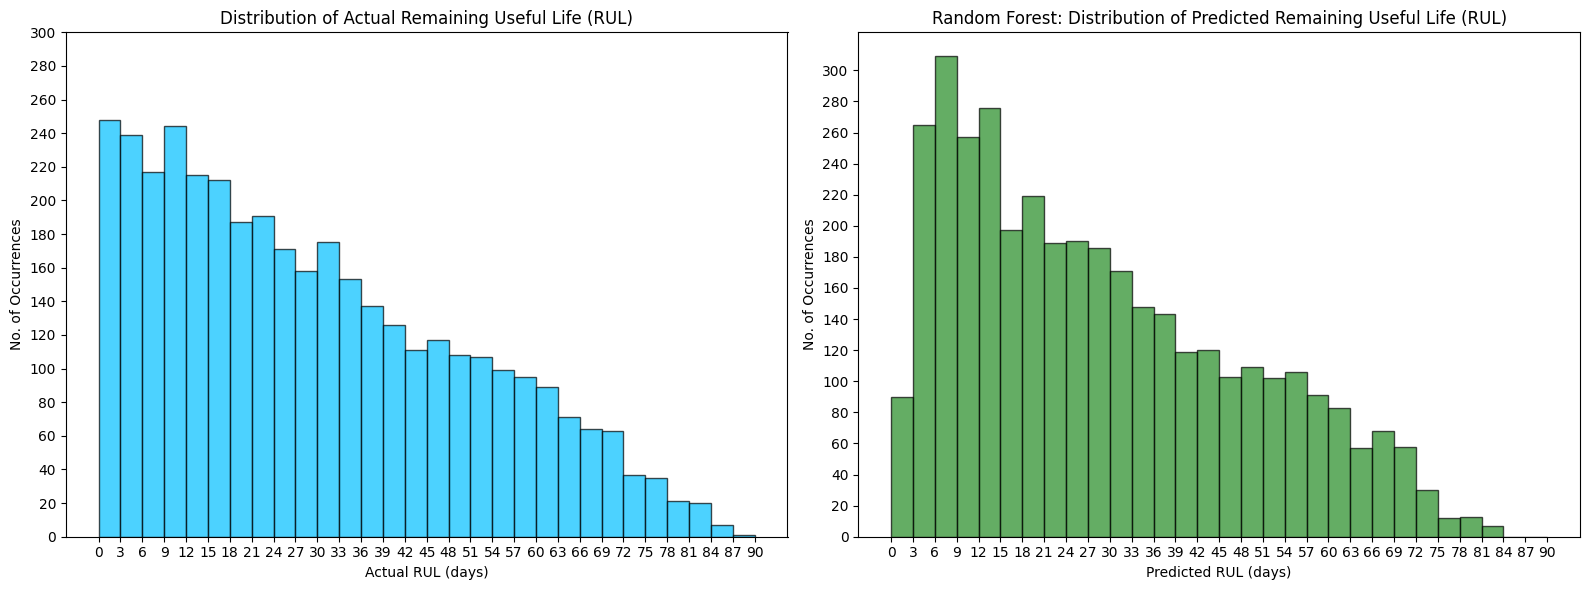

In [117]:
plot_histograms_parallel(y_true=y_test, 
                         y_pred=y_pred_rfr,
                         titles=("Distribution of Actual Remaining Useful Life (RUL)", "Random Forest: Distribution of Predicted Remaining Useful Life (RUL)"),
                         colors=('deepskyblue', 'forestgreen'),
                         save_path='../img/histogram_parallel_random_forest.png')

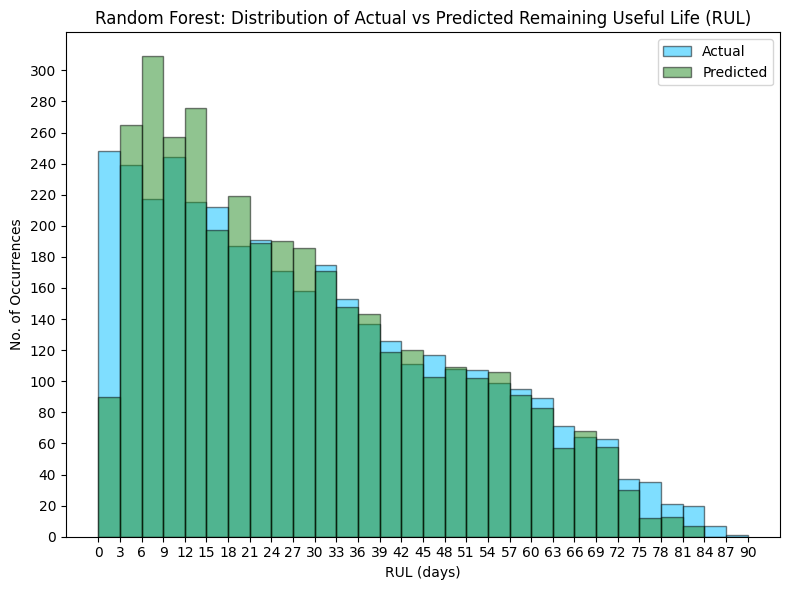

In [118]:
plot_histograms_stacked(y_true=y_test, 
                        y_pred=y_pred_rfr, 
                        title="Random Forest: Distribution of Actual vs Predicted Remaining Useful Life (RUL)",
                        actual_color='deepskyblue', 
                        predicted_color='forestgreen',
                        save_path='../img/histogram_stacked_random_forest.png')

## Calculating time complexity

### Splitting the data from 10% to 90% of its original train set size

In [14]:
X_1, X_9, y_1, y_9 = train_test_split(X_train, y_train, test_size=0.9, random_state=0)
X_2, X_8, y_2, y_8 = train_test_split(X_train, y_train, test_size=0.8, random_state=0)
X_3, X_7, y_3, y_7 = train_test_split(X_train, y_train, test_size=0.7, random_state=0)
X_4, X_6, y_4, y_6 = train_test_split(X_train, y_train, test_size=0.6, random_state=0)
X_5, _, y_5, _ = train_test_split(X_train, y_train, test_size=0.5, random_state=0)

### Decision Tree

In [15]:
dtr = DecisionTreeRegressor(max_depth=10, min_samples_split=2)

# Dictionary to store average training times for each split
average_training_times_dt = {}

# Loop over different splits (10% to 90%)
for i in range(1, 10):
    # List to store training times for each trial
    training_times = []
    
    for trial in range(3):
        start_time = time.time()
        X_train = globals()['X_' + str(i)]
        y_train = globals()['y_' + str(i)]
        dtr.fit(X_train, y_train)
        training_times.append(time.time() - start_time)
    
    # Calculate average training time for the current split
    average_training_time = sum(training_times) / len(training_times)
    
    # Store average training time for the current split
    average_training_times_dt[f'{i}0%'] = average_training_time

In [16]:
average_training_times_dt

{'10%': 2.5491179625193277,
 '20%': 5.022056182225545,
 '30%': 7.994984865188599,
 '40%': 11.095441023508707,
 '50%': 14.581520557403564,
 '60%': 20.868056933085125,
 '70%': 25.010571002960205,
 '80%': 29.800883213678997,
 '90%': 39.593971252441406}

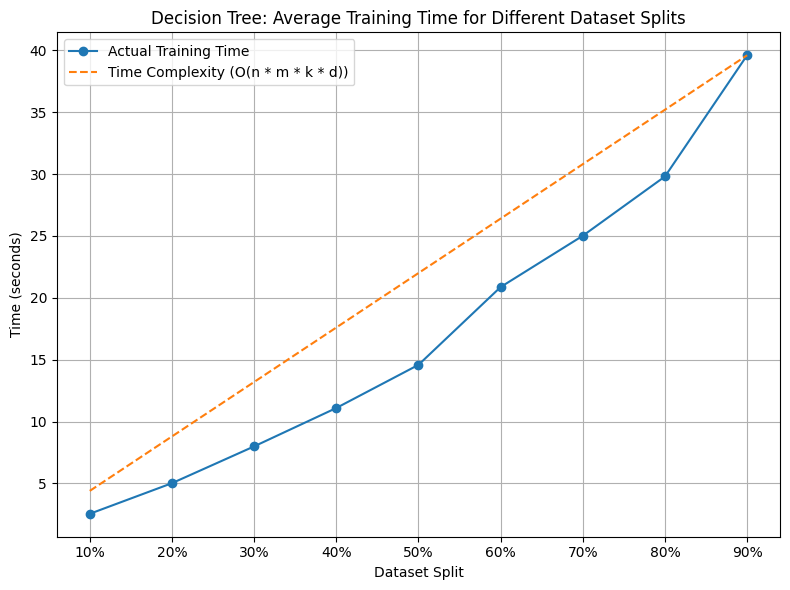

In [21]:
def theoretical_time_complexity_dt(n_values, m, k, d):
    max_actual_time = max(list(average_training_times_dt.values()))
    scaling_factor = max_actual_time / (max(n_values) * m * k * d)
    return [n * m * k * d * scaling_factor for n in n_values]

plt.figure(figsize=(8, 6))

# Plot actual training times
plt.plot(list(average_training_times_dt.keys()), 
         list(average_training_times_dt.values()), 
         marker='o', label='Actual Training Time')

# Calculate and plot theoretical time complexity
n_values = [len(globals()['X_' + str(i)]) for i in range(1, 10)]
# print(n_values)
m = 30  # Number of features
k = 10  # Number of unique values per feature
d = 10  # Maximum depth

plt.plot(list(average_training_times_dt.keys()), 
         theoretical_time_complexity_dt(n_values, m, k, d), 
         linestyle='--', label='Time Complexity (O(n * m * k * d))')

plt.xlabel('Dataset Split')
plt.ylabel('Time (seconds)')
plt.title("Decision Tree: Average Training Time for Different Dataset Splits")
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.savefig('../img/time_complexity_decision_tree.png')
plt.show()

### Random Forest (with feature selection)

In [24]:
rfr = RandomForestRegressor(n_trees=3, max_depth=10, min_samples_split=2, feature_selection=True)

# Dictionary to store average training times for each split
average_training_times_rf = {}

# Loop over different splits (10% to 90%)
for i in range(1, 10):
    # List to store training times for each trial
    training_times = []
    
    for trial in range(3):
        start_time = time.time()
        X_train = globals()['X_' + str(i)]
        y_train = globals()['y_' + str(i)]
        rfr.fit(X_train, y_train)
        training_times.append(time.time() - start_time)
    
    # Calculate average training time for the current split
    average_training_time = sum(training_times) / len(training_times)
    
    # Store average training time for the current split
    average_training_times_rf[f'{i}0%'] = average_training_time

In [25]:
average_training_times_rf

{'10%': 0.8786288102467855,
 '20%': 1.977901776631673,
 '30%': 2.479338804880778,
 '40%': 3.492875655492147,
 '50%': 4.707544803619385,
 '60%': 6.446864604949951,
 '70%': 8.983768622080484,
 '80%': 9.851601839065552,
 '90%': 13.798580408096313}

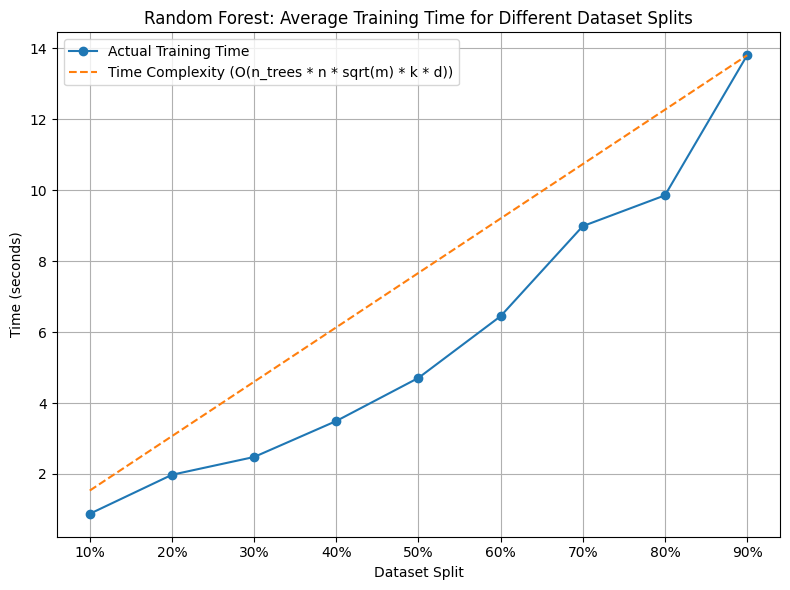

In [26]:
def theoretical_time_complexity_rf(n_values, m, k, d, n_trees):
    max_actual_time = max(list(average_training_times_rf.values()))
    scaling_factor = max_actual_time / (max(n_values) * (m ** 0.5) * k * d * n_trees)
    return [n * (m ** 0.5) * k * d * n_trees * scaling_factor for n in n_values]

plt.figure(figsize=(8, 6))

# Plot actual training times
plt.plot(list(average_training_times_rf.keys()), 
         list(average_training_times_rf.values()), 
         marker='o', label='Actual Training Time')

# Calculate and plot theoretical time complexity
n_values = [len(globals()['X_' + str(i)]) for i in range(1, 10)]
# print(n_values)
m = 30  # Number of features
k = 10  # Number of unique values per feature
d = 10  # Maximum depth
n_trees = 3  # Number of trees

plt.plot(list(average_training_times_rf.keys()), 
         theoretical_time_complexity_rf(n_values, m, k, d, n_trees), 
         linestyle='--', 
         label='Time Complexity (O(n_trees * n * sqrt(m) * k * d))')

plt.xlabel('Dataset Split')
plt.ylabel('Time (seconds)')
plt.title("Random Forest: Average Training Time for Different Dataset Splits")
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.savefig('../img/time_complexity_random_forest.png')
plt.show()